In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpy as np
%matplotlib inline
import time

In [0]:
def one_hot(values,n_values=10):
    n_v = np.maximum(n_values, np.max(values) + 1)
    oh=np.eye(n_v)[values]
    return oh

def get_cifar():
    tr=np.float32(np.load('CIFAR_10.npy'))
    tr_lb=np.int32(np.load('CIFAR_labels.npy'))
    tr=tr.reshape((-1,np.prod(np.array(tr.shape)[1:4])))
    train_data=tr[0:45000]/255.
    train_labels=one_hot(tr_lb[0:45000])
    val_data=tr[45000:]/255.
    val_labels=one_hot(tr_lb[45000:])
    
    test_data=np.float32(np.load('CIFAR_10_test.npy'))
    test_data=test_data.reshape((-1,np.prod(np.array(test_data.shape)[1:4])))
    test_data=test_data/255.
    test_labels=one_hot(np.int32(np.load('CIFAR_labels_test.npy')))
    return (train_data, train_labels), (val_data, val_labels), (test_data, test_labels)

In [0]:
def conv_relu_layer(x,filter_size=[3,3],dim=[1]):

    shape=filter_size+[x.get_shape().as_list()[-1],dim]
    
    W = tf.get_variable('W',shape=shape)
    b = tf.get_variable('b',shape=[dim],initializer=tf.zeros_initializer) 
    
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
    relu = tf.nn.relu(conv + b)
    return(relu)

In [0]:
def fully_connected_layer(input,dim):
    flat_dim=np.int32(np.array(input.get_shape().as_list())[1:].prod())
    input_flattened = tf.reshape(input, shape=[-1,flat_dim])
    shape=[flat_dim,dim]
    
    W_fc = tf.get_variable('W',shape=shape) 
    b_fc = tf.get_variable('b',shape=[dim],initializer=tf.zeros_initializer)
    
    fc = tf.matmul(input_flattened, W_fc) + b_fc
    return(fc)

In [0]:
def build_cnn(x_image, y_):
    pool_ksize=[1,2,2,1]
    pool_strides=[1,2,2,1]
    with tf.variable_scope("conv1"):
            relu1 = conv_relu_layer(x_image, filter_size=[3, 3],dim=64)
            
    with tf.variable_scope("conv2"):
            relu2 = conv_relu_layer(relu1, filter_size=[3, 3],dim=64)
            pool1 = tf.nn.max_pool(relu2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            
    with tf.variable_scope("conv3"):
            relu3 = conv_relu_layer(pool1, filter_size=[3, 3], dim=128)
            
    with tf.variable_scope("conv4"):
            relu4 = conv_relu_layer(relu3, filter_size=[3, 3], dim=128)
            pool2 = tf.nn.max_pool(relu4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            
    with tf.variable_scope("conv5"):
            relu5 = conv_relu_layer(pool2, filter_size=[3, 3],dim=256)
            pool3 = tf.nn.max_pool(relu5, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
            
    with tf.variable_scope("fc1"):
            fc1 = fully_connected_layer(pool3, dim=256)
            fc1r=tf.nn.relu(fc1)
   
    with tf.variable_scope("fc2"):
            fc2 = fully_connected_layer(fc1r, dim=10)
            fc2s = tf.nn.softmax(fc2)

    fc2 = tf.identity(fc2, name="OUT")

    with tf.variable_scope('cross_entropy_loss'):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=fc2),name="LOSS")

    with tf.variable_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name="ACC")
    return cross_entropy, accuracy, fc2

In [0]:
def get_stats(x, y_, data,labels,fc2):
    t1=time.time()
    loss=0.
    acc=0.
    delta=1000
    rr=np.arange(0, data.shape[0], delta)
    for i in rr:
        fc2_out = fc2.eval(feed_dict={x: data[i:i+delta], y_:labels[i:i+delta]})
        log_sf = logsumexp(fc2_out,axis=1).reshape((fc2_out.shape[0],1)) - fc2_out
        loss += np.mean(np.sum(labels[i:i+delta]*log_sf, axis=1))
        acc += np.mean(np.equal(np.argmax(fc2_out, axis=1),np.argmax(labels[i:i+delta], axis=1)))
    acc = acc/np.float32(len(rr))
    loss = loss/np.float32(len(rr))
    return loss, acc

In [0]:
def run_epoch(x, y_, lr_, step_size, train,val,ii,batch_size,train_step_new):
        t1=time.time()
        # Randomly shuffle the training data
        np.random.shuffle(ii)
        tr=train[0][ii]
        y=train[1][ii]
        lo=0.
        acc=0.
        
        # Run disjoint batches on shuffled data
        for j in np.arange(0,len(y),batch_size):
            batch=(tr[j:j+batch_size],y[j:j+batch_size])
            train_step_new.run(feed_dict={x: batch[0], y_: batch[1], lr_: step_size})
        print('Epoch time',time.time()-t1)

In [20]:
def get_data(data_set):
    if (data_set=="cifar"):
        return(get_cifar())
            
def train(batch_size=500,
          step_size=.0015,
          num_epochs=50,
          num_train=45000,
          dim=32,
          nchannels=3,
          optimizer="Adam",
          model_name="model",
          ckpt='./tmp/model.ckpt'):

  x = tf.placeholder(tf.float32, shape=[None, dim*dim*nchannels],name="x")
  x_image = tf.reshape(x, [-1, dim, dim, nchannels])

  y_ = tf.placeholder(tf.float32, shape=[None,10],name="y")

  lr_ = tf.placeholder(tf.float32, shape=[],name="learning_rate")

  loss = []
  vloss= []
  acc =[]
  vacc=[]

  with tf.Session() as sess:
      train,val,test=get_data(data_set="cifar")

      cross_entropy, accuracy, fc2 = build_cnn(x_image, y_)

      # Optimizer
      if (optimizer=="Adam"):
          train_step = tf.train.AdamOptimizer(learning_rate=lr_).minimize(cross_entropy)
      elif (optimizer=="SGD"):
          train_step = tf.train.GradientDescentOptimizer(learning_rate=lr_).minimize(cross_entropy)
      elif (optimizer=="Adagrad"):
          train_step = tf.train.AdagradOptimizer(learning_rate=lr_).minimize(cross_entropy)

      writer = tf.summary.FileWriter("./tmp/output", sess.graph)
      # Initialize variables
      sess.run(tf.global_variables_initializer())

      ii=np.arange(0,num_train,1)

      for i in range(num_epochs):
          run_epoch(x, y_, lr_, step_size,train,val,ii,batch_size,train_step)
          lo,ac = get_stats(x, y_, train[0][0:num_train],train[1][0:num_train], fc2)
          loss.append(lo)
          acc.append(ac)

          vlo,vac = get_stats(x, y_, val[0],val[1], fc2)
          vloss.append(vlo)
          vacc.append(vac)

          if (np.mod(i,10)==0):
              print('Epoch',i,'Train loss, accuracy',lo,ac)
              print('EPoch',i,'Validation loss, accuracy',vlo,vac)
              
      # Save model
      saver = tf.train.Saver()
      save_path = saver.save(sess, ckpt)
      print("Model saved in path: %s" % save_path)
      
      return x, y_, loss, acc, vloss, vacc, cross_entropy, accuracy, saver
    
tf.reset_default_graph()
x, y_, loss, acc, vloss, vacc, cross_entropy, accuracy, saver = train()


Epoch time 18.26474142074585
Epoch 0 Train loss, accuracy 1.5080735603226556 0.4595555555555556
EPoch 0 Validation loss, accuracy 1.49426953458786 0.45899999999999996
Epoch time 15.691040754318237
Epoch time 15.707324981689453
Epoch time 15.761514902114868
Epoch time 15.772007703781128
Epoch time 15.776997327804565
Epoch time 15.770281791687012
Epoch time 15.77762246131897
Epoch time 15.77733588218689
Epoch time 15.781656503677368
Epoch time 15.775804042816162
Epoch 10 Train loss, accuracy 0.15420665821234386 0.9482444444444444
EPoch 10 Validation loss, accuracy 0.8606590542554855 0.7692000000000001
Epoch time 15.776431322097778
Epoch time 15.770198345184326
Epoch time 15.784810066223145
Epoch time 15.776038408279419
Epoch time 15.776192665100098
Epoch time 15.782877206802368
Epoch time 15.770604133605957
Epoch time 15.773587465286255
Epoch time 15.776363849639893
Epoch time 15.76035189628601
Epoch 20 Train loss, accuracy 0.03150684373378754 0.9896888888888886
EPoch 20 Validation loss,

In [24]:
def test(dim=32,
         nchannels=3,
         accuracy=accuracy,
         ckpt='./tmp/model.ckpt'):
  
  train,val,test=get_data(data_set="cifar")
  with tf.Session() as sess:
    saver.restore(sess, ckpt)
    print('test accuracy %g' % sess.run(accuracy, feed_dict={x: test[0], y_:test[1]}))
    print('test loss %g' % sess.run(cross_entropy, feed_dict={x: test[0], y_:test[1]}))
  return

test()

INFO:tensorflow:Restoring parameters from ./tmp/model.ckpt
test accuracy 0.7527
test loss 1.98008


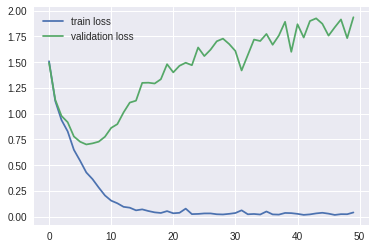

6


In [25]:
plt.plot(loss, label='train loss')
plt.plot(vloss, label='validation loss')
plt.legend()
plt.show()
# plt.savefig("loss.png")
print(np.argmin(np.array(vloss)))

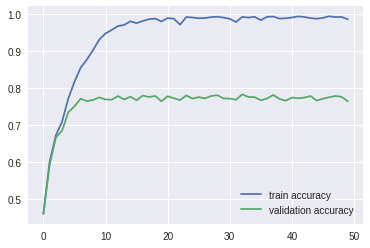

0.7691999999999999

In [26]:
plt.plot(acc, label='train accuracy')
plt.plot(vacc, label='validation accuracy')
plt.legend()
plt.show()
# plt.savefig("acc.png")
vacc[13]

In [1]:
ls

datalab/  drive/


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1buil

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
ls

datalab/  drive/


In [6]:
cd drive/

/content/drive


In [7]:
ls

10张1寸[以5寸(3R)冲洗].jpg
2014 Internship/
2369 rex/
Academic History; View Academic History Select Level and Type; ...; Registration and Records Tab.pdf
Class/
convertio.co/
Coursera/
Cover Letter.docx
Documents/
Downloads/
drive/
Emma_Watson/
Emma Watson_face/
Final book - Molly.pdf
Fuchia/
Georgetown.pdf
GRE/
hw5/
I20.pdf
i901_payment_confirmation_07052015.PDF
images.jpeg
Medical_Record.pdf
ml-note/
Pictures/
resume.pdf
Resume-Rex Zhou.docx
Rex-Zhou-Resume.pdf
Rex和小伙伴们/
rzhou12/
Sign.jpg
UIUC.pdf
Zhou.pdf
简历.pdf
简历_栾盈月.pdf


In [8]:
cd hw5/

/content/drive/hw5


In [11]:
pwd

'/content/drive/hw5'

In [1]:
ls

datalab/


In [19]:
!tensorboard --logdir=/content/drive/hw5/tmp

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-05-06 20:07:47.978021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:898] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2018-05-06 20:07:47.978336: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1344] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 0000:00:04.0
totalMemory: 11.17GiB freeMemory: 443.38MiB
2018-05-06 20:07:47.978373: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1423] Adding visible gpu devices: 0
2018-05-06 20:07:48.351957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:911] Device interconnect StreamExe

In [29]:
cd tmp/

/content/drive/hw5/tmp


In [30]:
pwd

'/content/drive/hw5/tmp'